# Temat testów
### Czy istnieje istotna statystycznie różnica w czasie odpowiedzi w zależności od cech osobowych badanych?

In [2]:
import pandas as pd

from functions.tests.independent_groups.two_groups import ttest_or_mannwhitney_test
from functions.tests.independent_groups.more_than_two_groups import anova_or_kruskalwallis_test
from functions.tests.posthoc import posthocNemenyi_test
from functions.set_preparations import prepare_row
from functions.others import choose_dominant_kind, change_to_ranges_roz, change_to_ranges_podst

In [3]:
df_quest = pd.read_csv(
    '/Users/martasolarz/Studies/Thesis/data/survey.csv',
).fillna('NO_VAL')

df_quest = df_quest[df_quest.ID != 6] # odrzucony uczestnik ze względu na metryki eye trackingowe

# zagregowane kolumny - podział na tych co pisali i nie pisali danej matury:
df_quest['MAT'] = df_quest['MAT_roz'].apply(lambda x: x if x == 'NO_VAL' else 'VAL' )
df_quest['POL'] = df_quest['JP_roz'].apply(lambda x: x if x == 'NO_VAL' else 'VAL' )
df_quest['HIST'] = df_quest['HIST_roz'].apply(lambda x: x if x == 'NO_VAL' else 'VAL')
df_quest['Typ_uczenia'] = df_quest.apply(choose_dominant_kind, axis=1)
df_quest['Kierunek_studiów'] = df_quest['Kierunek_studiów'].apply(lambda x: 'MISMaP Geografia' if x == 'Geografia, w ramach studiów międzyobszarowych' else x)
df_quest['JP_podst'] = df_quest['JP_podst'].apply(change_to_ranges_podst)
df_quest['MAT_podst'] = df_quest['MAT_podst'].apply(change_to_ranges_podst)
df_quest['JP_roz'] = df_quest['JP_roz'].apply(change_to_ranges_roz)
df_quest['MAT_roz'] = df_quest['MAT_roz'].apply(change_to_ranges_roz)
df_quest['HIST_roz'] = df_quest['HIST_roz'].apply(change_to_ranges_roz)
df_quest['FIZ_roz'] = df_quest['FIZ_roz'].apply(change_to_ranges_roz)

df_time = pd.read_csv('/Users/martasolarz/Studies/Thesis/Master_thesis/prepare_datasets/sets/times.csv')

df_merge = df_quest.merge(df_time, on='ID')
df_merge.head()

,ID,Płeć,Rok_urodzenia,Kierunek_studiów,Rok_studiów,Specjalność,Wady_wzroku,Daltonizm,Ilość_snu,JP_podst,...,Duration_2a,Duration_2b,Duration_3a,Duration_3b,SumTime_all,SumTime_a,SumTime_b,SumTime_1,SumTime_2,SumTime_3
0,1,M,2002,MISMaP Geografia,2,SPOŁ-EKO,0,1,6,4,...,54481,58697,56314,63897,276921,138810,138110,43531,113178,120211
1,2,M,2003,Gospodarka przestrzenna,1,NO_VAL,1,1,<6,2,...,42248,85329,47948,129427,459647,156426,303219,154693,127577,177375
2,3,M,2001,Geografia,3,GEOINF,0,1,8,2,...,45165,32732,8000,61197,299890,121995,177892,152793,77897,69197
3,4,K,2000,Geografia,3,GEOINF,0,1,8,2,...,12449,37715,60980,101795,337437,119477,217956,124494,50164,162775
4,5,K,2002,Geografia,3,GEOINF,0,1,7,2,...,55931,22132,34898,62930,271458,158809,112644,95562,78063,97828


Przygotowanie zbiorów:

In [4]:
# zsumowane wartości
df_sumAll = df_merge.rename(columns={'SumTime_all':'time'})
df_sumA = df_merge.rename(columns={'SumTime_a':'time'})
df_sumB = df_merge.rename(columns={'SumTime_b':'time'})
df_sum1 = df_merge.rename(columns={'SumTime_1':'time'})
df_sum2 = df_merge.rename(columns={'SumTime_2':'time'})
df_sum3 = df_merge.rename(columns={'SumTime_3':'time'})

In [5]:
dfs = [df_sumAll, df_sumA, df_sumB, df_sum1, df_sum2, df_sum3]
names = {
    1: 'Zsumowane wszystkie grafiki:',
    2: 'Zsumowane grafiki A:',
    3: 'Zsumowane grafiki B:',
    4: 'Zsumowane grafiki 1:',
    5: 'Zsumowane grafiki 2:',
    6: 'Zsumowane grafiki 3:',
}

columns = ['Płeć', 'Rok_urodzenia', 'Kierunek_studiów',
       'Rok_studiów', 'Specjalność', 'Wady_wzroku', 'Ilość_snu',
       'JP_podst', 'MAT_podst', 'JP_roz', 'MAT_roz', 'HIST_roz',
       'Samopocz', 'Stres', 'Zmęcz', 'Czyt_map', 'Podziel_uwg', 'Analit_myśl',
       'Spostrzeg', 'Czyt_ze_zroz', 'Wzrokowiec', 'Słuchowiec', 'Kinestetyk', 'MAT', 'POL', 'HIST', 'Typ_uczenia']

**H0:** Nie ma istotnej statystycznie zależności między czasem odpowiedzi a wartością cechy X.

**H1:** Istnieje istotna statystycznie zależność między czasem odpowiedzi a wartością cechy X.

**Poziom istotności:** $\alpha=0.05$

In [6]:
ALPHA = 0.05

In [7]:
results = []
for col in columns:
    print('################################################')
    print(col)
    results.append('\n')
    results.append(col)
    for i, df in enumerate(dfs):
        print('-------------------------')
        print(names[i+1])
        if col in ['Płeć', 'Wady_wzroku', 'POL', 'MAT', 'HIST']:
            if col == 'Płeć':
                var1, var2 = 'K', 'M'
            elif col == 'Wady_wzroku':
                var1, var2 = 0, 1
            else:
                var1, var2 = 'VAL', 'NO_VAL'
            p = ttest_or_mannwhitney_test(df, 'time', col, ALPHA, var1, var2)
        else:
            p = anova_or_kruskalwallis_test(df, 'time', col, ALPHA)
        results.append(p)

################################################
Płeć
-------------------------
Zsumowane wszystkie grafiki:
Conducting normality test...
Mann-Whitney test conducted...
U-statistic: 217.0
p-value: 0.5655940812648745
Brak podstaw do odrzucenia H0.
-------------------------
Zsumowane grafiki A:
Conducting normality test...
Conducting homogeneity variance test...
T-Student test conducted...
T-statistic: -0.17229982625247603
p-value: 0.8641162144260337
Brak podstaw do odrzucenia H0.
-------------------------
Zsumowane grafiki B:
Conducting normality test...
Conducting homogeneity variance test...
T-Student test conducted...
T-statistic: 0.9123909929338655
p-value: 0.36731531323404143
Brak podstaw do odrzucenia H0.
-------------------------
Zsumowane grafiki 1:
Conducting normality test...
Conducting homogeneity variance test...
T-Student test conducted...
T-statistic: 0.7749353237769059
p-value: 0.4431735195920954
Brak podstaw do odrzucenia H0.
-------------------------
Zsumowane grafiki 2

In [8]:
# posthoc tests
posthocNemenyi_test(df_sum2, 'time', 'Rok_urodzenia')
print()
posthocNemenyi_test(df_sum1, 'time', 'JP_podst')

+------+----------+----------+----------+----------+----------+
|      |     2002 |     2003 |     2001 |     2000 |     2004 |
+======+==========+==========+==========+==========+==========+
| 2002 | 1        | 0.764018 | 0.960921 | 0.73919  | 0.584269 |
+------+----------+----------+----------+----------+----------+
| 2003 | 0.764018 | 1        | 0.364138 | 0.439093 | 0.151043 |
+------+----------+----------+----------+----------+----------+
| 2001 | 0.960921 | 0.364138 | 1        | 0.896714 | 0.882736 |
+------+----------+----------+----------+----------+----------+
| 2000 | 0.73919  | 0.439093 | 0.896714 | 1        | 0.998702 |
+------+----------+----------+----------+----------+----------+
| 2004 | 0.584269 | 0.151043 | 0.882736 | 0.998702 | 1        |
+------+----------+----------+----------+----------+----------+

+----+----------+----------+---------+----------+
|    |        4 |        2 |       3 |        1 |
+====+==========+==========+=========+==========+
|  4 | 1        |

In [9]:
posthocNemenyi_test(df_sumAll, 'time', 'JP_roz')
print()
posthocNemenyi_test(df_sumB, 'time', 'JP_roz')
print()
posthocNemenyi_test(df_sum1, 'time', 'JP_roz')
print()
posthocNemenyi_test(df_sum3, 'time', 'JP_roz')

+----+----------+----------+----------+----------+
|    |        4 |        3 |        0 |        2 |
+====+==========+==========+==========+==========+
|  4 | 1        | 0.992107 | 0.073875 | 0.996057 |
+----+----------+----------+----------+----------+
|  3 | 0.992107 | 1        | 0.045699 | 0.97431  |
+----+----------+----------+----------+----------+
|  0 | 0.073875 | 0.045699 | 1        | 0.331673 |
+----+----------+----------+----------+----------+
|  2 | 0.996057 | 0.97431  | 0.331673 | 1        |
+----+----------+----------+----------+----------+

+----+----------+----------+----------+----------+
|    |        4 |        3 |        0 |        2 |
+====+==========+==========+==========+==========+
|  4 | 1        | 0.992107 | 0.073875 | 0.996057 |
+----+----------+----------+----------+----------+
|  3 | 0.992107 | 1        | 0.045699 | 0.97431  |
+----+----------+----------+----------+----------+
|  0 | 0.073875 | 0.045699 | 1        | 0.331673 |
+----+----------+----------+--

In [10]:
posthocNemenyi_test(df_sumAll, 'time', 'Samopocz')
print()
posthocNemenyi_test(df_sumB, 'time', 'Samopocz')
print()
posthocNemenyi_test(df_sum2, 'time', 'Samopocz')
print()
posthocNemenyi_test(df_sum3, 'time', 'Samopocz')

+----+----------+----------+----------+----------+
|    |        4 |        3 |        5 |        2 |
+====+==========+==========+==========+==========+
|  4 | 1        | 0.066631 | 0.219529 | 0.04679  |
+----+----------+----------+----------+----------+
|  3 | 0.066631 | 1        | 0.90017  | 0.994794 |
+----+----------+----------+----------+----------+
|  5 | 0.219529 | 0.90017  | 1        | 0.793153 |
+----+----------+----------+----------+----------+
|  2 | 0.04679  | 0.994794 | 0.793153 | 1        |
+----+----------+----------+----------+----------+

+----+----------+----------+----------+----------+
|    |        4 |        3 |        5 |        2 |
+====+==========+==========+==========+==========+
|  4 | 1        | 0.066631 | 0.219529 | 0.04679  |
+----+----------+----------+----------+----------+
|  3 | 0.066631 | 1        | 0.90017  | 0.994794 |
+----+----------+----------+----------+----------+
|  5 | 0.219529 | 0.90017  | 1        | 0.793153 |
+----+----------+----------+--

In [11]:
posthocNemenyi_test(df_sum1, 'time', 'Czyt_ze_zroz')

+----+----------+----------+----------+----------+----------+
|    |        4 |        2 |        3 |        1 |        5 |
+====+==========+==========+==========+==========+==========+
|  4 | 1        | 0.317559 | 0.213382 | 0.171966 | 0.45264  |
+----+----------+----------+----------+----------+----------+
|  2 | 0.317559 | 1        | 0.99895  | 0.86144  | 0.999045 |
+----+----------+----------+----------+----------+----------+
|  3 | 0.213382 | 0.99895  | 1        | 0.934242 | 0.98565  |
+----+----------+----------+----------+----------+----------+
|  1 | 0.171966 | 0.86144  | 0.934242 | 1        | 0.7678   |
+----+----------+----------+----------+----------+----------+
|  5 | 0.45264  | 0.999045 | 0.98565  | 0.7678   | 1        |
+----+----------+----------+----------+----------+----------+


Podsumowanie:
Istotne statystycznie:
- Rok urodzenia: grafiki 2 (słabo się różnicuje)
- Matura: j.polski podstawa: grafiki 1 (słabo się różnicuje)
- Matura: j.polski rozszerzony: wszystkie grafiki, grafiki B, grafiki 1, grafiki 3 (dla wszystkich: 0 vs 3)
- Samopoczucie: wszystkie, B, 2, 3 (dla wszystkich: 2 vs 4)
- Czytanie ze zrouzumieniem: grafiki: 1 (słabo się różnicuje)

Dla każdej grafiki oddzielnie:

In [12]:
columns = ['Płeć', 'Rok_urodzenia', 'Kierunek_studiów',
           'Rok_studiów', 'Specjalność', 'Wady_wzroku', 'Ilość_snu',
           'JP_podst', 'MAT_podst', 'JP_roz', 'MAT_roz', 'HIST_roz',
           'Samopocz', 'Stres', 'Zmęcz', 'Czyt_map', 'Podziel_uwg', 'Analit_myśl',
           'Spostrzeg', 'Czyt_ze_zroz', 'Wzrokowiec', 'Słuchowiec', 'Kinestetyk', 'MAT', 'POL', 'HIST', 'Typ_uczenia']

prefix = ['1a', '1b', '2a', '2b', '3a', '3b']
for col in columns:
    print('##############################################################')
    print(col)
    results.append('\n')
    results.append(col)
    for pref in prefix:
        print('-------------------------------------')
        print(pref)
        
        if col in ['Płeć', 'Wady_wzroku', 'POL', 'MAT', 'HIST']:
            if col == 'Płeć':
                var1, var2 = 'K', 'M'
            elif col == 'Wady_wzroku':
                var1, var2 = 0, 1
            else:
                var1, var2 = 'VAL', 'NO_VAL'
            p =ttest_or_mannwhitney_test(df_merge, f'Duration_{pref}', col, ALPHA, var1, var2)
        else:
            p = anova_or_kruskalwallis_test(df_merge, f'Duration_{pref}', col, ALPHA)
        
        results.append(p)

##############################################################
Płeć
-------------------------------------
1a
Conducting normality test...
Mann-Whitney test conducted...
U-statistic: 199.0
p-value: 0.9345839653717953
Brak podstaw do odrzucenia H0.
-------------------------------------
1b
Conducting normality test...
Mann-Whitney test conducted...
U-statistic: 243.0
p-value: 0.1984769534047992
Brak podstaw do odrzucenia H0.
-------------------------------------
2a
Conducting normality test...
Mann-Whitney test conducted...
U-statistic: 215.0
p-value: 0.6031799173850656
Brak podstaw do odrzucenia H0.
-------------------------------------
2b
Conducting normality test...
Conducting homogeneity variance test...
T-Student test conducted...
T-statistic: 0.8008699953844416
p-value: 0.42818608611489506
Brak podstaw do odrzucenia H0.
-------------------------------------
3a
Conducting normality test...
Conducting homogeneity variance test...
T-Student test conducted...
T-statistic: -0.29004373041

In [13]:
posthocNemenyi_test(df_merge, 'Duration_1b', 'JP_podst')
print()
posthocNemenyi_test(df_merge, 'Duration_1b', 'JP_roz')
print()
posthocNemenyi_test(df_merge, 'Duration_3b', 'JP_roz')

+----+----------+----------+---------+----------+
|    |        4 |        2 |       3 |        1 |
+====+==========+==========+=========+==========+
|  4 | 1        | 0.353282 | 0.09182 | 1        |
+----+----------+----------+---------+----------+
|  2 | 0.353282 | 1        | 0.83523 | 0.353282 |
+----+----------+----------+---------+----------+
|  3 | 0.09182  | 0.83523  | 1       | 0.09182  |
+----+----------+----------+---------+----------+
|  1 | 1        | 0.353282 | 0.09182 | 1        |
+----+----------+----------+---------+----------+

+----+----------+----------+----------+----------+
|    |        4 |        3 |        0 |        2 |
+====+==========+==========+==========+==========+
|  4 | 1        | 0.992107 | 0.073875 | 0.996057 |
+----+----------+----------+----------+----------+
|  3 | 0.992107 | 1        | 0.045699 | 0.97431  |
+----+----------+----------+----------+----------+
|  0 | 0.073875 | 0.045699 | 1        | 0.331673 |
+----+----------+----------+----------+--

In [14]:
posthocNemenyi_test(df_merge, 'Duration_2b', 'Samopocz')
print()
posthocNemenyi_test(df_merge, 'Duration_3a', 'Samopocz')

+----+----------+----------+----------+----------+
|    |        4 |        3 |        5 |        2 |
+====+==========+==========+==========+==========+
|  4 | 1        | 0.066631 | 0.219529 | 0.04679  |
+----+----------+----------+----------+----------+
|  3 | 0.066631 | 1        | 0.90017  | 0.994794 |
+----+----------+----------+----------+----------+
|  5 | 0.219529 | 0.90017  | 1        | 0.793153 |
+----+----------+----------+----------+----------+
|  2 | 0.04679  | 0.994794 | 0.793153 | 1        |
+----+----------+----------+----------+----------+

+----+----------+----------+----------+----------+
|    |        4 |        3 |        5 |        2 |
+====+==========+==========+==========+==========+
|  4 | 1        | 0.066631 | 0.219529 | 0.04679  |
+----+----------+----------+----------+----------+
|  3 | 0.066631 | 1        | 0.90017  | 0.994794 |
+----+----------+----------+----------+----------+
|  5 | 0.219529 | 0.90017  | 1        | 0.793153 |
+----+----------+----------+--

Podsumowanie - dla każdej grafiki:

Istotne statystycznie:
- Samopoczucie: 2b, 3a (2 vs 4)
- JP_roz: 1b, 3b (0 vs 3)
- JP_podst: 1b (słabo się różnicuje)

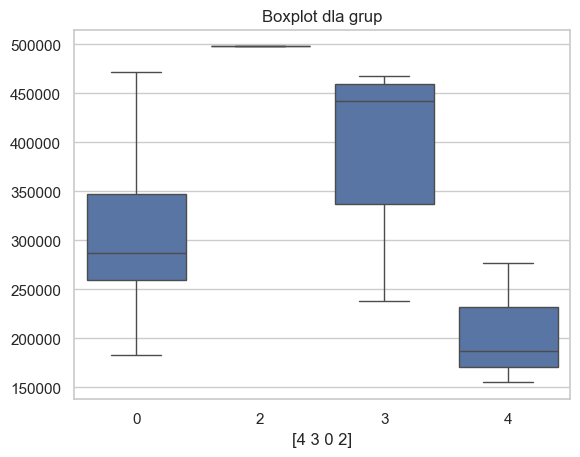

In [22]:
from functions.plots import plot_multi_boxplot

plot_multi_boxplot(df_merge, 'JP_roz', 'SumTime_all', df_merge['JP_roz'].unique(), '')

In [16]:
import csv
with open('./results/czas.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    row = []
    for item in results:
        if item != '\n':
            row.append(item)
        else:
            writer.writerow(row)
            row = []
    if row:  # Sprawdzamy, czy jest coś do zapisania w ostatnim wierszu
        writer.writerow(row)